In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from shifterator import shifts
import re
import itertools
import collections
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime 

In [4]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

In [7]:
comment_df['text'][0]

"The following discussion is an archived record of a request for comment. Please do not modify it.  No further edits should be made to this discussion.  A summary of the conclusions reached follows.\nThis RfC is now redundent, given the predeeding RfC (#RfC about use of YouTube video as source for lead) has been withdrawn by the OP and a reworking of the lead has been workshopped in the section that follows (#RfCs here don't seem necessary). The video appears to be WP:SELFPUB. There is certainly no third party editorial oversight being applied. As such, it may be used (subject to conditions) as a source of information about themselves. It should not be used with a Wiki voice - a matter of significance that appears to have been overlooked. It is also a WP:RSPRIMARY and guidance on usage expressed there should also be applied. Regard, Cinderella157 (talk) 09:04, 11 October 2019 (UTC)\n\nShould a YouTube video  of the subject of the article talking at an event be acceptable as the only so

In [13]:
print(f'There are {len(rfc_df)} individual rfc')
print(f'There are {len(comment_df)} individual commments')
print(f'there are {len(users_df)} individual users')

There are 2011 individual rfc


In [25]:
print(f"{len(users_df[users_df['editcount'].isna()])} users do not exist in database anymore " )

707 users do not exist in database anymore 


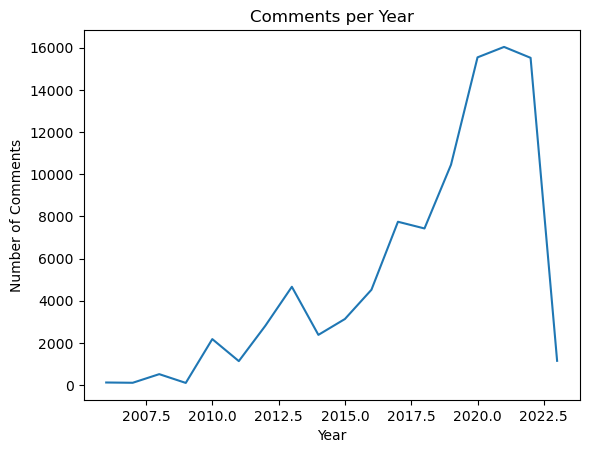

In [6]:
# convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract the year from date column and create a new column
df['year'] = df['date'].dt.year

# count the number of comments per year and create a new dataframe
count_df = df.groupby('year').size().reset_index(name='counts')

# plot the count dataframe
plt.plot(count_df['year'], count_df['counts'])
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Comments per Year')
plt.show()

In [26]:
rfc_df.head()

,rfc_id,discussion_title,discussion_result_comment_id,discussion_input_comment,project
0,0,RfC about use of YouTube video as primary sour...,0,1,wikipedia
1,1,[[Scriptural texts]] ([[WP:RSPSCRIPTURE]]),26,27,wikipedia
2,2,RfC on article scope,116,117,wikipedia
3,3,Request for comment on first sentence of lead,126,127,wikipedia
4,4,"RfC about naming ""Soldier F"" in the Bloody Sun...",169,170,wikipedia


In [9]:
# define list of wikis to include
wikis_to_include = ['enwiki','eswiki','frwiki','dewiki','zhwiki','jawiki','plwiki','ruwiki','itwiki','nlwiki','ptwiki']

# create new column with sum of edit counts for desired wikis
def sum_edit_counts(edit_count_dict, wikis_to_include):
    try:
        if edit_count_dict:
            edit_count_dict['wikipedia_project_sum'] = sum(edit_count_dict[wiki] for wiki in wikis_to_include)
            return edit_count_dict
        else:
            return edit_count_dict
    except KeyError:
        print(edit_count_dic)

users_df['editcount'] = users_df['editcount'].apply(lambda x: sum_edit_counts(x, wikis_to_include))

In [8]:
# drop rows with any NA values
df = users_df.dropna()
# projects to calculate median edit count for
projects = ['metawiki', 'wikidatawiki', 'wikipedia_project_sum']

# create list of edit counts for each project
edit_counts = [[d.get(p, 0) for d in df['editcount']] for p in projects]

# calculate median edit count for each project
median_edit_counts = [pd.Series(ec).median() for ec in edit_counts]
for i, p in enumerate(projects):
    print(f"The median edit count for {p} is {median_edit_counts[i]}")

The median edit count for metawiki is 7.0
The median edit count for wikidatawiki is 39.0
The median edit count for wikipedia_project_sum is 0.0


In [12]:
# drop rows with any NA values
df = users_df.dropna()
# convert registration_date to datetime object
df['user_registration'] = pd.to_datetime(df['user_registration'])

# calculate account age
df['account_age'] = (datetime.now() - df['user_registration']).dt.days

median_account_age = df['account_age'].median()

print(f"The median account age are {median_account_age} days")

The median account age are 4851.0 days


/tmp/ipykernel_133906/2938285238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_registration'] = pd.to_datetime(df['user_registration'])
/tmp/ipykernel_133906/2938285238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['account_age'] = (datetime.now() - df['user_registration']).dt.days


In [13]:
df = users_df.dropna()
# create a list of all unique dictionary keys in the permissions column
all_keys = set().union(*df['permissions'].apply(dict.keys).tolist())

# create a dictionary with all unique values for each key
all_values = {}
for key in all_keys:
    values = set()
    for d in df['permissions']:
        if key in d:
            values.add(d[key])
    all_values[key] = list(values)

# print the unique values for each key
for key, values in all_values.items():
    print(f'{key}: {values}')
# create a function to get the key for a given value
def get_permission_key(d, value):
    for key, val in d.items():
        if val == value:
            return True
    return None

# create a new column for each value and assign the corresponding key
df['user_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'user'))
df['sysop_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'sysop'))
df['bureaucrat_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'bureaucrat'))
df['bot_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'bot'))

# preview the updated dataframe
print(df.head())

dewiki: ['editor', 'autoreview', 'user', 'bot']
frwiki: ['rollbacker', 'abusefilter', 'user', 'interface-admin', 'ipblock-exempt', 'bureaucrat', 'bot', 'accountcreator', 'sysop']
jawiki: ['abusefilter', 'user', 'ipblock-exempt', 'extendedconfirmed', 'bot', 'eliminator']
eswiki: ['patroller', 'rollbacker', 'abusefilter', 'user', 'confirmed', 'ipblock-exempt', 'autopatrolled', 'bureaucrat', 'checkuser', 'bot']
mediawikiwiki: ['user', 'interface-admin', 'autopatrolled', 'bureaucrat', 'bot', 'transwiki', 'translationadmin', 'sysop']
itwiki: ['rollbacker', 'user', 'interface-admin', 'ipblock-exempt', 'autopatrolled', 'bureaucrat', 'checkuser', 'bot', 'accountcreator', 'sysop']
ptwiki: ['user', 'autoreviewer', 'bureaucrat', 'checkuser', 'bot', 'eliminator', 'sysop']
metawiki: ['patroller', 'user', 'interface-admin', 'ipblock-exempt', 'autopatrolled', 'wmf-supportsafety', 'global-renamer', 'steward', 'bureaucrat', 'checkuser', 'bot', 'centralnoticeadmin', 'oauthadmin', 'massmessage-sender', '

/tmp/ipykernel_17119/1795827437.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'user'))
/tmp/ipykernel_17119/1795827437.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sysop_permission'] = df['permissions'].apply(lambda x: get_permission_key(x, 'sysop'))
/tmp/ipykernel_17119/1795827437.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [14]:
# count the number of rows where sysop permission is present
num_sysop_rows = df['sysop_permission'].notnull().sum()

# print the result
print(f"Number of rows with sysop permission: {num_sysop_rows}")
# count the number of rows where sysop permission is present
num_sysop_rows = df['user_permission'].notnull().sum()

# print the result
print(f"Number of rows with sysop permission: {num_sysop_rows}")
# count the number of rows where sysop permission is present
num_sysop_rows = df['bureaucrat_permission'].notnull().sum()

# print the result
print(f"Number of rows with sysop permission: {num_sysop_rows}")
# count the number of rows where sysop permission is present
num_sysop_rows = df['bot_permission'].notnull().sum()

# print the result
print(f"Number of rows with sysop permission: {num_sysop_rows}")

Number of rows with sysop permission: 307
Number of rows with sysop permission: 7807
Number of rows with sysop permission: 65
Number of rows with sysop permission: 3


In [15]:
df = pd.read_csv('rfc_comments.csv')
grouped = df.groupby('project')
# create a dictionary of dataframes, with one dataframe for each unique value in the "class" column
dfs = {name: group for name, group in grouped}

# access each dataframe using its corresponding key
df_wikipedia_text = dfs['wikipedia']['text'].tolist()
df_wikidata_text = dfs['wikidata']['text'].tolist()
df_meta_text = dfs['meta.wikimedia']['text'].tolist()
# download the stopwords data if you haven't already
nltk.download('stopwords')

# get the set of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dylan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
def remove_punctuation(txt):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
def clean_text(txt):
    """Removes punctuation, changes to lowercase, removes
        stopwords, removes "animal" and "crossing", and
        calculates word frequencies.

    Parameters
    ----------
    txt : string
        A text string that you want to clean.

    Returns
    -------
    Words and frequencies
    """
    
    tmp = [remove_punctuation(t) for t in txt]
    tmp = [t.lower().split() for t in tmp]
    
    tmp = [[w for w in t if not w in stop_words]
              for t in tmp]
    tmp = [[w for w in t if not w in ['animal', 'crossing']]
                     for t in tmp]
    
    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return tmp

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


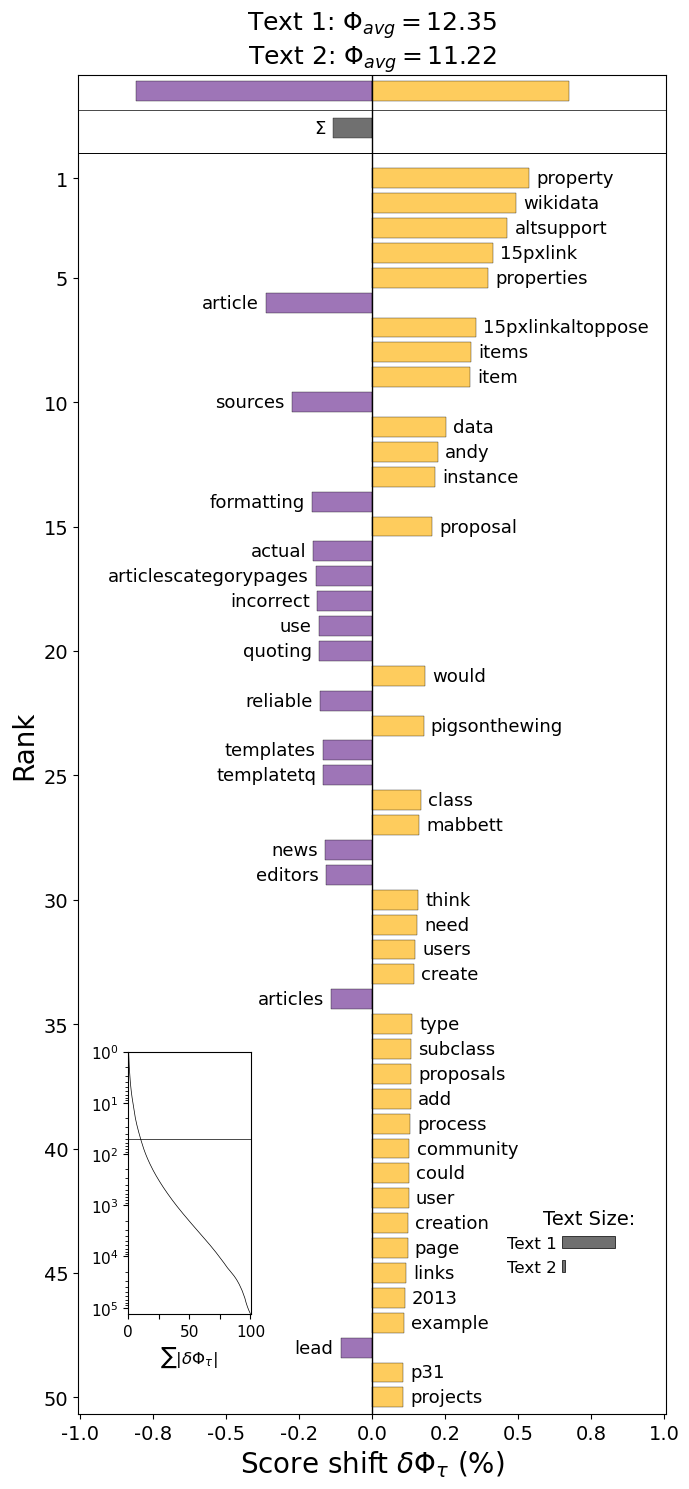

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.35\nText 2: $\\Phi_{avg}=$11.22'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [20]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_wikidata_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph() 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


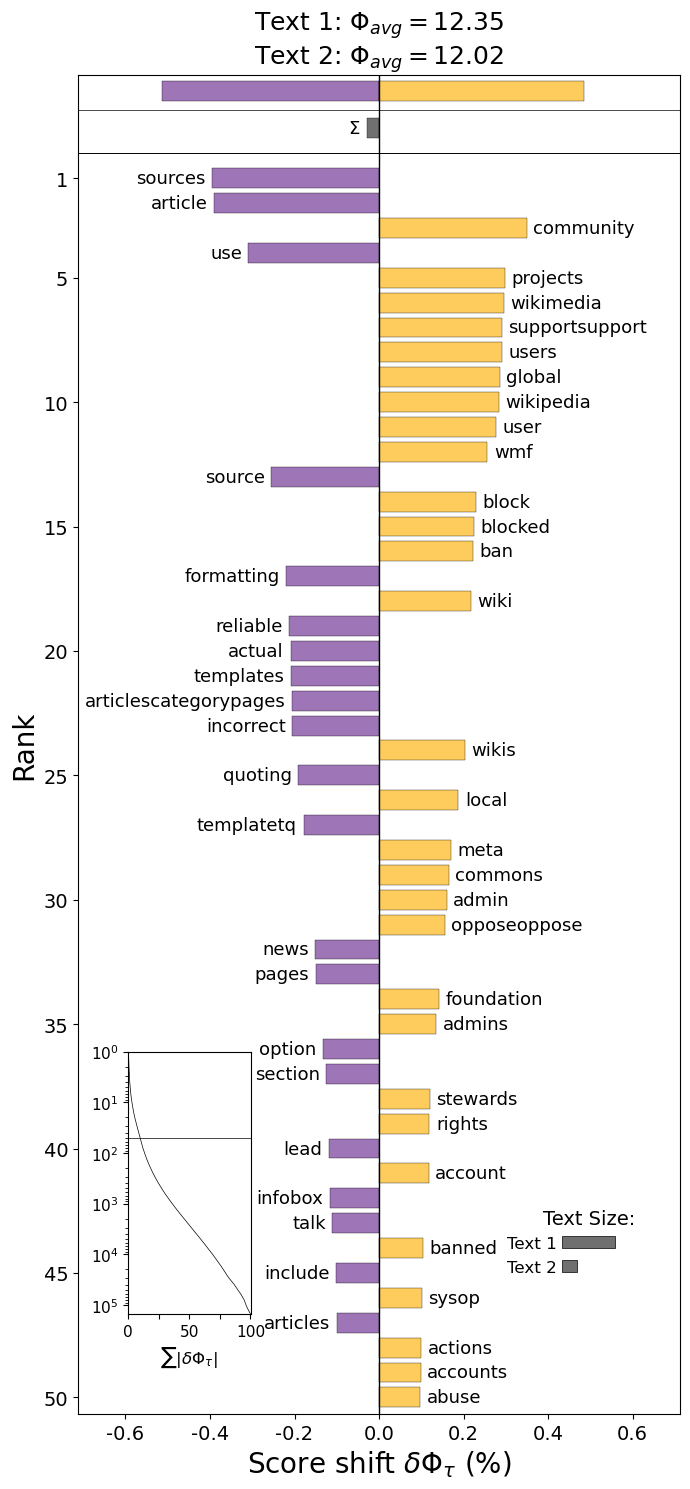

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.35\nText 2: $\\Phi_{avg}=$12.02'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [21]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_meta_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph() 